In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
x_train_full, x_test = x_train_full / 255.0, x_test / 255.0

x_train = x_train_full[:-5000]
y_train = y_train_full[:-5000]

x_valid = x_train_full[-5000:]
y_valid = y_train_full[-5000:]

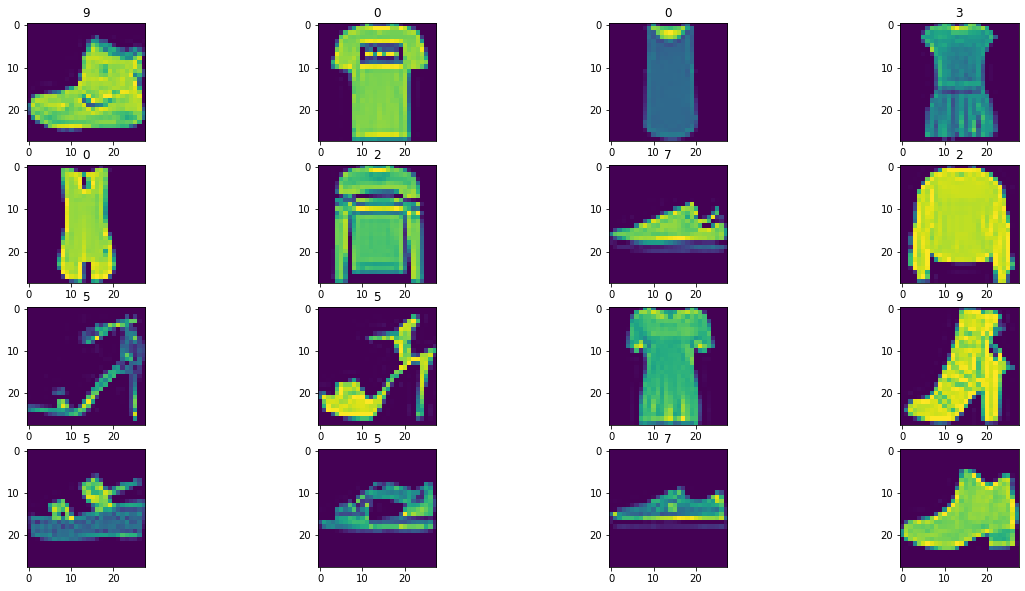

In [4]:
fig, axes = plt.subplots(4,4,figsize=(20,10))

for ax,img,title in zip(np.ravel(axes),x_train,y_train):
    ax.imshow(img)
    ax.set_title(title)

In [118]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100),
    keras.layers.Dense(200),
    keras.layers.Dense(400),
    keras.layers.Dense(10, activation='softmax'),
])
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [15]:
from copy import copy

K = keras.backend
def find_learning_rate(model, X, y, epochs=1, 
                       batch_size=32, 
                       min_rate=1e-3, 
                       max_rate=1e1):
    
    class ExpLR(keras.callbacks.Callback):
        def __init__(self, factor):
            self.factor = factor
            self.rates = []
            self.losses = []
            
        def on_batch_end(self, batch, logs=None):
            lr = K.get_value(self.model.optimizer.lr)
            self.rates.append(lr)
            self.losses.append(logs['loss'])
            K.set_value(self.model.optimizer.lr, lr*self.factor)
    
    iters = len(X) * epochs // batch_size
    factor = (max_rate/min_rate) ** (1/iters)
    
    init_weights = model.get_weights()
    init_lr = K.get_value(model.optimizer.lr
                         )
    
    exp_lr = ExpLR(factor)
    break_on_nan = keras.callbacks.TerminateOnNaN()
    K.set_value(model.optimizer.lr, min_rate)
    hist = model.fit(X,y,epochs=epochs, batch_size=batch_size,
                    callbacks=[exp_lr, break_on_nan]
                    )
    
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    
    return exp_lr.rates, exp_lr.losses
    

In [ ]:

rates, losses = find_learning_rate(model,
                                   x_train,
                                   y_train,
                                  min_rate=1e-7,
                                  max_rate=1e-1,)

(0.20150961, 1.3800653219223022)

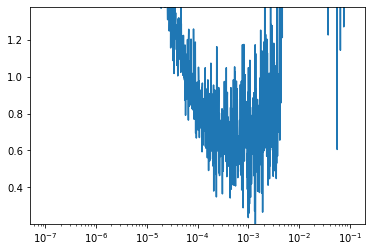

In [120]:
plt.plot(rates, losses)
plt.gca().set_xscale('log')
plt.ylim([min(losses), (losses[0] + min(losses))/2])

In [150]:
import os
from pathlib import Path
# K.set_value(model.optimizer.lr, 1e-4)
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(lr=1e-4),
             metrics=['accuracy'])

MODEL_DIR = Path('models/10_lecture/')
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(MODEL_DIR/'fmnist_stage_1.h5')

In [159]:
model = keras.models.load_model(MODEL_DIR/'fmnist_stage_3.h5')
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(patience=5)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
model_ckp_cb = keras.callbacks.ModelCheckpoint(str(MODEL_DIR/'fmnist_stage_4.h5'),
                                               save_best_only=True)
model.fit(x_train,y_train,
          epochs=30,
          validation_data=(x_valid,y_valid),
          callbacks=[reduce_lr_cb, early_stopping_cb, model_ckp_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 12s 213us/sample - loss: 0.4107 - accuracy: 0.8563 - val_loss: 0.4327 - val_accuracy: 0.8484
Epoch 2/30
55000/55000 [==============================] - 14s 261us/sample - loss: 0.4074 - accuracy: 0.8569 - val_loss: 0.4099 - val_accuracy: 0.8590
Epoch 3/30
55000/55000 [==============================] - 16s 285us/sample - loss: 0.4046 - accuracy: 0.8582 - val_loss: 0.4176 - val_accuracy: 0.8540
Epoch 4/30
55000/55000 [==============================] - 15s 271us/sample - loss: 0.4015 - accuracy: 0.8589 - val_loss: 0.4039 - val_accuracy: 0.8588
Epoch 5/30
55000/55000 [==============================] - 16s 282us/sample - loss: 0.3980 - accuracy: 0.8604 - val_loss: 0.4219 - val_accuracy: 0.8498
Epoch 6/30
55000/55000 [==============================] - 14s 253us/sample - loss: 0.3969 - accuracy: 0.8609 - val_loss: 0.4203 - val_accuracy: 0.8514
Epoch 7/30
55000/55000 [=====================

### Deep and wide model

In [30]:
def make_model(lr=1e-3):
    input_ = keras.layers.Input(shape=[28,28])
    flatten = keras.layers.Flatten()(input_)
    hidden1 = keras.layers.Dense(100, activation='relu')(flatten)
    hidden2 = keras.layers.Dense(200, activation='relu')(hidden1)    
    concat = keras.layers.Concatenate()([flatten, hidden2])
    output = keras.layers.Dense(10, activation='softmax')(concat)
    model = keras.Model(inputs=[input_], outputs=[output])
    optimizer = keras.optimizers.RMSprop(lr=1e-3)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                 metrics=['accuracy'])
    return model

model = make_model()

In [31]:
rates, losses = find_learning_rate(model, 
                                   x_train, 
                                   y_train, 
                                   batch_size=8,
                                  min_rate=1e-5,
                                  max_rate=1e0)

Train on 55000 samples
55000/55000 [==============================] - 56s 1ms/sample - loss: 8.4558 - accuracy: 0.6789


(0.0, 2.276408)

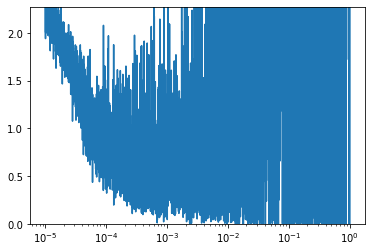

In [35]:
plt.plot(rates, losses)
plt.gca().set_xscale('log')
plt.ylim([min(losses), (losses[0]+min(losses))]) 

In [36]:
model = make_model(lr=2e-5)
hist = model.fit(x_train, y_train, 
          epochs=5,
          batch_size=8, 
          validation_split=0.2)

Train on 44000 samples, validate on 11000 samples
Epoch 1/5
44000/44000 [==============================] - 42s 953us/sample - loss: 0.5529 - accuracy: 0.8183 - val_loss: 0.4824 - val_accuracy: 0.8518
Epoch 2/5
44000/44000 [==============================] - 43s 977us/sample - loss: 0.5116 - accuracy: 0.8489 - val_loss: 0.5866 - val_accuracy: 0.8534
Epoch 3/5
44000/44000 [==============================] - 48s 1ms/sample - loss: 0.5156 - accuracy: 0.8538 - val_loss: 0.5688 - val_accuracy: 0.8545
Epoch 4/5
44000/44000 [==============================] - 43s 986us/sample - loss: 0.5312 - accuracy: 0.8575 - val_loss: 0.5112 - val_accuracy: 0.8607
Epoch 5/5
44000/44000 [==============================] - 38s 870us/sample - loss: 0.5447 - accuracy: 0.8615 - val_loss: 0.5472 - val_accuracy: 0.8642


## The subclassing API

In [40]:
keras.Model is keras.models.Model

True

In [61]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units, activation='relu', **kwargs):
        super().__init__(kwargs)
        self.units = units
        self.activation = activation
        self.flat = keras.layers.Flatten()
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        
    def call(self, inputs, training=None, mask=None):
        flat = self.flat(inputs)
        res_1 = self.hidden1(flat)
        res_2 = self.hidden2(res_1)
        return res_2
    
    def save_weights(self,filepath,overwrite=True,save_format=None,):
        pass
    
model = WideAndDeepModel(30, activation='relu')
model.compile(loss='mse')
model.fit(x_train[:500], y_train[:500])

Train on 500 samples
500/500 [==============================] - 0s 795us/sample - loss: 18.3019


In [63]:
model.save_weights('models/10_lecture/wide_and_deep_stage_1.h5')